## Final Project: Reddit 

Question/problem: Can we predict a user's age based off of characteristics of their submission?

In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from pmaw import PushshiftAPI
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.externals import joblib
import praw

## Dataset Creation

We used an API to scrape data on the 500,000 most recent reddit post submissions on r/teenagers.

In [2]:
api = PushshiftAPI()
subreddit = "teenagers"
subs = api.search_submissions(subreddit=subreddit, limit = 500000)
df = pd.DataFrame(subs)
df.to_csv('/teenagersData.csv', header=True)

Done


## Preprocessing and Manipulation

In [153]:
# initial dataset—uncleaned
dfRaw = pd.read_csv('teenagersData.csv', low_memory = False)
dfRaw.head()

,Unnamed: 0,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_template_id,author_flair_text,author_flair_text_color,author_flair_type,...,is_created_from_ads_ui,author_is_blocked,gilded,distinguished,suggested_sort,top_awarded_type,removal_reason,crosspost_parent,crosspost_parent_list,live_audio
0,0,[],True,OWO_UDEAD,NaN,"[{'e': 'text', 't': '17'}]",f2e6204c-9bc7-11e1-af72-12313b078981,17,dark,richtext,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,[],True,[deleted],NaN,NaN,NaN,NaN,dark,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,[],True,[deleted],NaN,NaN,NaN,NaN,dark,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,[],False,MidiMidi_445,NaN,"[{'e': 'text', 't': '15'}]",ef54aab6-9bc7-11e1-a725-12313b0c247a,15,dark,richtext,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,[],False,j_p_x_f_r_d,NaN,"[{'e': 'text', 't': '14'}]",ee2caff8-9bc7-11e1-bb7b-12313b07b651,14,dark,richtext,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
list(dfRaw.columns)

['Unnamed: 0',
 'all_awardings',
 'allow_live_comments',
 'author',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_template_id',
 'author_flair_text',
 'author_flair_text_color',
 'author_flair_type',
 'author_fullname',
 'author_patreon_flair',
 'author_premium',
 'awarders',
 'can_mod_post',
 'contest_mode',
 'created_utc',
 'domain',
 'full_link',
 'gildings',
 'id',
 'is_crosspostable',
 'is_meta',
 'is_original_content',
 'is_reddit_media_domain',
 'is_robot_indexable',
 'is_self',
 'is_video',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_template_id',
 'link_flair_text',
 'link_flair_text_color',
 'link_flair_type',
 'locked',
 'media_only',
 'no_follow',
 'num_comments',
 'num_crossposts',
 'over_18',
 'parent_whitelist_status',
 'permalink',
 'pinned',
 'pwls',
 'retrieved_on',
 'score',
 'selftext',
 'send_replies',
 'spoiler',
 'stickied',
 'subreddit',
 'subreddit_id',
 'subreddit_subscribers',
 'subreddit

We decided to select only a few characteristics to keep, i.e., id number, author, title, link flair text (category), score, upvote ratio, number of comments, and author flair text (which would be indicative of age)

In [154]:
# keep only necessary columns
df = dfRaw[['id','author','title', 'link_flair_text', 'score','upvote_ratio', 'num_comments', 'author_flair_text']]
# also maybe add contains media/picture, post length
# make boxplot w/ age & link_flair_text
df.head()

,id,author,title,link_flair_text,score,upvote_ratio,num_comments,author_flair_text
0,lt0yrt,OWO_UDEAD,"im bored, who have interesting story to tell",Social,8,0.80,48,17
1,lt0yl2,[deleted],its raininggggggggggggg,Other,5,1.00,16,NaN
2,lt0yjt,[deleted],i want the world slugsoul to be engraved into ...,Art,2,0.75,6,NaN
3,lt0yip,MidiMidi_445,anyone need someone to talk to?,Serious,4,0.84,13,15
4,lt0y1b,j_p_x_f_r_d,I'm bored so ask me anything you want smh,Other,1,1.00,2,14


In [96]:
# examine different values of author_flair_text
df.author_flair_text.unique()

array(['17', nan, '15', '14', '13', '2 MILLION ATTENDEE', '16', '18',
       '16 | Bootleg psychologist', '19', 'OLD',
       'Springtime 🎋 Playlist Winner', '🎉 1,000,000 Attendee! 🎉',
       '💥1,500,000 Attendee💥', '🎂 10 year anniversary attendee 🎂',
       '16, MOD', 'Best user 2020', '18 | 🔰 Sorter of /new', '16 | Mod',
       '20 | You will always matter', '16; Best Original Comment of 2018',
       '18 | Pisscord Mod', 'Team Kiwi Bird ',
       '17 | discord.gg/teenagers', '❤ 17 I #1 Homie ❤',
       '17 | mod | she/her', '16 | Bedenke das Ende',
       'Best wholesome submission 2020', '15 | Moderator',
       '200K Attendee', "14 | feelin' cute, might ban someone later idk",
       '17 | mod | she/her | Christian ✞ ', '900K Attendee',
       '🎉 500K Attendee 🎉', '700K Attendee',
       '200K Attendee; Best Female Selfie of 2017', '400K Attendee',
       '19 | Best creative post 2020', '16 | MOD | she/her | dQw4w9WgXcQ',
       '❤ 18 I #1 Homie ❤', '16; Best Inside Joke of 2019 '

We then kept only the submissions with an "author_flair_text" that states their age.

In [155]:
listAges = ['13','14','15','16','17','18', '19', 'OLD']
df = df[df["author_flair_text"].isin(listAges)]
df = df.rename(columns={"author_flair_text": "age"})
#df['age'] = pd.to_numeric(df.author_flair_text)
#df.drop(columns='author_flair_text')

print(df.shape[0])
df.to_csv('df_cleaned.csv',header=True)

259669


Adding another column: is there a swear word in the title? 1 if yes, 0 if no.

In [156]:
swearList = ['fuck', 'shit', 'bitch', 'crap', 'dick','pussy','ass','crap','damn','hell','cunt', 'slut','cock']
df['swear'] = df['title'].apply(lambda x: 1 if any(substring in x.lower() for substring in swearList)
                             else 0)

In [157]:
df.tail(5)

,id,author,title,link_flair_text,score,upvote_ratio,num_comments,age,swear
499990,l7vnp5,XiphiaLikesBones,This song is on loop in my head constantly and...,Media,2,1.0,3,16,0
499992,l7vnev,Mg-rod-sim,Man fuck origami,Other,1,1.0,7,15,1
499997,l7y5k9,that1redditer0703,I know the actual winner of the Kong V Godzill...,Advice,1,1.0,8,17,0
499998,l7y5h1,Basic_Requirement561,Stonks,Other,1,1.0,0,15,0
499999,l7y4xs,DarkDelight__,Siege anyone?,Social,1,1.0,4,15,0


Here, we are adding two new columns for title character length and username character length, which we will end up usinnng in the models rather than the title and author themselves.

In [158]:
df['title_length']=df['title'].str.len()
df['author_length'] = df['author'].str.len()
df.tail()

,id,author,title,link_flair_text,score,upvote_ratio,num_comments,age,swear,title_length,author_length
499990,l7vnp5,XiphiaLikesBones,This song is on loop in my head constantly and...,Media,2,1.0,3,16,0,70,16
499992,l7vnev,Mg-rod-sim,Man fuck origami,Other,1,1.0,7,15,1,16,10
499997,l7y5k9,that1redditer0703,I know the actual winner of the Kong V Godzill...,Advice,1,1.0,8,17,0,53,17
499998,l7y5h1,Basic_Requirement561,Stonks,Other,1,1.0,0,15,0,6,20
499999,l7y4xs,DarkDelight__,Siege anyone?,Social,1,1.0,4,15,0,13,13


### Splitting the data into train-test (80:20 split)

In [159]:
train = random.sample(range(df.shape[0]),round(df.shape[0]*.8))
test= range(df.shape[0])
dfTrain = df.iloc[train]
print(dfTrain.shape[0])
dfTest = df.drop(df.iloc[train].index)
dfTest.shape[0]
dfTest.shape[0] + dfTrain.shape[0]

207735


259669

## Exploratory Data Analysis & Visualizations

Creating a new dataset based on the training data that adds a column of ages as numeric values to calculate summary statistics and correlations; however, any age of 'OLD' needs to be dropped in order for this to work.

In [160]:
dfTrainNumAge = dfTrain.copy()
dfTrainNumAge = dfTrainNumAge[dfTrainNumAge.age != 'OLD']
dfTrainNumAge['age_num'] = pd.to_numeric(dfTrainNumAge.age)
dfTrainNumAge.head()

#df['age'] = pd.to_numeric(df.author_flair_text)
#df.drop(columns='author_flair_text')

,id,author,title,link_flair_text,score,upvote_ratio,num_comments,age,swear,title_length,author_length,age_num
489144,qopj6c,Aryan_4657,I have a feelings for a girl but i dont know i...,Advice,1,1.0,0,14,0,75,10,14
400116,od8rat,PixelDestroyer07,My three little brothers are-,Other,1,1.0,7,14,0,29,16,14
215980,p1tl4p,BaLsAmIc007,shuba shuba duck (´◉◞⊖◟◉｀),Art,1,1.0,4,17,0,26,11,17
460593,pwwzez,coles2345,Shifting realities and religion are synonymous...,Rant,1,1.0,2,14,0,76,9,14
34919,jwz9z8,SomeoneThatLikesRBLX,posting horny shitposts every day until I_____...,Other,2,0.6,58,14,1,55,20,14


In [161]:
dfTrainNumAge.describe()

,score,upvote_ratio,num_comments,swear,title_length,author_length,age_num
count,206627.000000,206627.000000,206627.000000,206627.000000,206627.000000,206627.000000,206627.000000
mean,7.309117,0.986317,15.742028,0.088551,45.022049,12.621385,15.462369
std,289.863182,0.062953,130.468241,0.284095,33.910421,3.834766,1.539975
min,0.000000,0.090000,0.000000,0.000000,1.000000,4.000000,13.000000
25%,1.000000,1.000000,2.000000,0.000000,23.000000,10.000000,14.000000
50%,1.000000,1.000000,7.000000,0.000000,36.000000,12.000000,15.000000
75%,1.000000,1.000000,14.000000,0.000000,57.000000,15.000000,17.000000
max,62139.000000,1.000000,25486.000000,1.000000,316.000000,20.000000,19.000000


22053
39302
47697
44247
31268
16539
5486
1143


<BarContainer object of 8 artists>

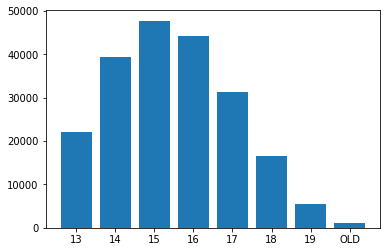

In [23]:
groupAge = dfTrain.groupby(['age'])
ageCount = []
for num in sorted(dfTrain.age.unique()):
    ageCount.append(groupAge.get_group(num).shape[0])
    print(groupAge.get_group(num).shape[0])

plt.bar(sorted(dfTrain.age.unique()), ageCount)

Mean (self-reported) age of  teenagers posting on the subreddit is 15.46, with the most common age being 15.

In [24]:
dfTrain['swear'].value_counts()[1] / dfTrain.shape[0]

0.0888295183767781

On average, 8.9% of submissions contain at least one swear word in the title

13
0.08334466965945676
14
0.0881634522416162
15
0.09117973876763738
16
0.09128302483784212
17
0.08740565434309837
18
0.08942499546526392
19
0.08439664600802041
OLD
0.07611548556430446


<BarContainer object of 8 artists>

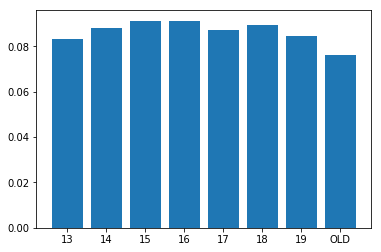

In [25]:
# % of submissions containing swear words by age
swearRate = []
for num in sorted(dfTrain.age.unique()):
    print(num)
    print(dfTrain[dfTrain.age==num].swear.value_counts()[1] / dfTrain[dfTrain.age==num].shape[0])
    swearRate.append(dfTrain[dfTrain.age==num].swear.value_counts()[1] / dfTrain[dfTrain.age==num].shape[0])
# % of swear words peaks at ages 15 & 16

plt.bar(sorted(dfTrain.age.unique()), swearRate)

In [130]:
dfTrainNumAge.corr().style.background_gradient(cmap='coolwarm')

,score,upvote_ratio,num_comments,swear,title_length,author_length,age_num
score,1,-0.0121927,0.0965771,-0.00160499,-0.00117602,-0.000637184,-0.00315846
upvote_ratio,-0.0121927,1,-0.011746,-0.00599778,0.0085673,-0.00127408,0.00900299
num_comments,0.0965771,-0.011746,1,-0.00194005,0.00308891,-0.00292577,0.00256823
swear,-0.00160499,-0.00599778,-0.00194005,1,0.114703,0.00628941,0.00235493
title_length,-0.00117602,0.0085673,0.00308891,0.114703,1,0.0211188,0.0589678
author_length,-0.000637184,-0.00127408,-0.00292577,0.00628941,0.0211188,1,-0.033454
age_num,-0.00315846,0.00900299,0.00256823,0.00235493,0.0589678,-0.033454,1


Based on this correlation matrix, none of the predictor variables have a strong correlation with the age. Title length is the strongest out of all of them, with a slightly positive association with age.

(0, 50)

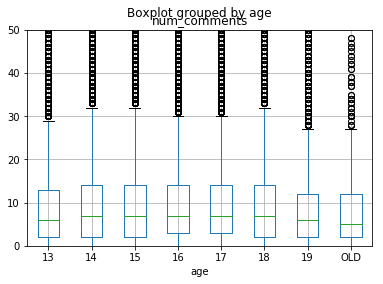

In [27]:
dfTrain.boxplot(column = 'num_comments', by = 'age')
plt.ylim(0,50)

(0, 100)

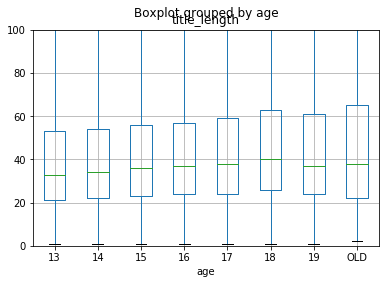

In [28]:
dfTrain.boxplot(column = 'title_length', by = 'age')
plt.ylim(0,100)

Based on the boxplot, it appears as though title character lengths generally increase as age increases, with a peak at 18 years old. However, this trend is fairly minor, confirming what we saw in the correlation matrix.

(0, 21)

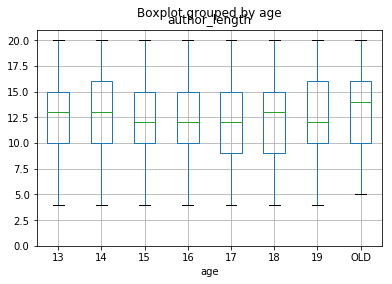

In [29]:
dfTrain.boxplot(column = 'author_length', by = 'age')
plt.ylim(0,21)

There does not appear to be a clear trend between the the username character length and age of a user.

In [30]:
# % of submissions containing swear words by age
groupAge = dfTrain.groupby(['age'])
ageCount = []

for num in sorted(dfTrain.age.unique()):
    ageCount.append(groupAge.get_group(num).shape[0])
    print(groupAge.get_group(num).shape[0])

#plt.bar(sorted(dfTrain.age.unique()), ageCount)

22053
39302
47697
44247
31268
16539
5486
1143


array(['Other', 'Discussion', 'Serious', 'Advice', 'Media', 'Social',
       'Meme', 'Rant', 'Art', 'Relationship', nan, 'AMA', 'Mod'],
      dtype=object)

### Takeaways
Because the (linear) correlations between our different predictor variables and the age of a user are weak, we are deciding to treat age like a categorical variable and trying to build a classification model.

## Model Creation

In [178]:
trainX = dfTrain.drop(columns = ['id','author','link_flair_text','title','age'])
trainY = dfTrain['age']

testX = dfTest.drop(columns = ['id','author','link_flair_text','title','age'])
testY = dfTest['age']

### Model 1: Logistic Regression
The first model that we are creating is a multinomial logistic regression model.

In [170]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 100)
model.fit(trainX, trainY)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(multi_class='multinomial')

In [171]:
predictors = trainX.columns
for var in range(len(predictors)):
    print('Variable: ', predictors[var])
    print('Coefficient:', round(model.coef_[0,var],3))
    print('\n')
print('Intercept: ', round(model.intercept_[0],3))

Variable:  score
Coefficient: 0.0


Variable:  upvote_ratio
Coefficient: -0.001


Variable:  num_comments
Coefficient: 0.003


Variable:  swear
Coefficient: -0.0


Variable:  title_length
Coefficient: 0.003


Variable:  author_length
Coefficient: 0.006


Intercept:  -0.001


Score and swear word presence appears to have no relationship with the age of the author. Upvote_ratio has a slighly negative relationship with age, while num_comments, title_length, and author_length have slightly positive relationships with age.

In [174]:
model.score(testX, testY)

0.2302730388570108

In [173]:
dfTest.age.value_counts()[0]/dfTest.shape[0]

0.2302537836484769

Our multinomial logistic regression model has an accuracy of 23.027%. However, the baseline accuracy (accuracy if we guessed the most common age every time) is 23.025%, so our does about as well as the baseline, if (very slightly) above.

### Model 2: KNN
Our second model uses K-nearest neighbors regression to categorize the data.

In [150]:
model2 = KNeighborsClassifier(n_neighbors = 8)
model2.fit(trainX, trainY)

predicted = model2.predict(testX)

model2.score(testX, testY)

0.21985597104016635

Here, the accuracy is 22%, which is slightly below our baseline accuracy.